# Toxic Comment Classification:
The Toxic Comment Classification app attempts to identify toxic comments using machine learning.

In [2]:
from IPython.display import HTML, display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script><strong>To toggle between dashboard and code: <a href="javascript:code_toggle()">click here</a>.<strong>
</script>''')

In [1]:
import pandas as pd
import numpy as np

import time
import gc
import warnings

from imageio import imread
from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import json
import ipykernel
import notebook.notebookapp
import requests

from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, train_test_split

import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer


start_time = time.time()
color= sns.color_palette()
eng_stopwords = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

lem = WordNetLemmatizer()
tokenizer= TweetTokenizer()

%matplotlib inline

In [2]:
def get_notebook_server_url():
    """
    Return the url of the current jupyter notebook server.
    """
    kernel_id = re.search(
        "kernel-(.*).json",
        ipykernel.connect.get_connection_file()
    ).group(1)
    servers = notebook.notebookapp.list_running_servers()
    for s in servers:
        response = requests.get(
            requests.compat.urljoin(s["url"], "api/sessions"),
            params={"token": s.get("token", "")}
        )
        for n in json.loads(response.text):
            if n["kernel"]["id"] == kernel_id:
                return s["url"]
            
f = open('log.log', 'a')
f.write('Notebook in use at: '+ str(datetime.now()) +' from: ' + get_notebook_server_url() +'\n')
f.write('--------------------------------------\n')
f.close()

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
x= train.iloc[:,2:].sum()

# Loading the trained data:

In [5]:
rowsums= train.iloc[:,2:].sum(axis=1)
train['clean']= (rowsums==0)
train['clean'].sum()
print('Total Comments =', len(train))
print('Total Clean Comments =',train['clean'].sum())
print('Total Tags =', x.sum())

Total Comments = 159571
Total Clean Comments = 143346
Total Tags = 35098


## Show totals for the trained data

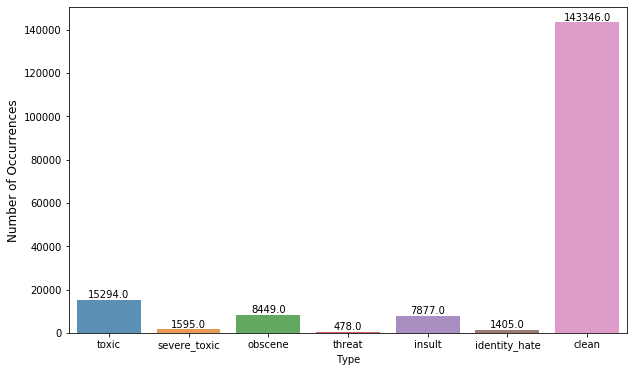

In [6]:
x= train.iloc[:,2:].sum()
plt.figure(figsize=(10,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.xlabel('Type')
plt.ylabel('Number of Occurrences', fontsize= 12)
rects= ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    heights = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, heights + 5, label, ha= 'center', va='bottom' )
    
plt.show()

### Comments with Multipal Tags:

Let's check how many comments have multiple tags.

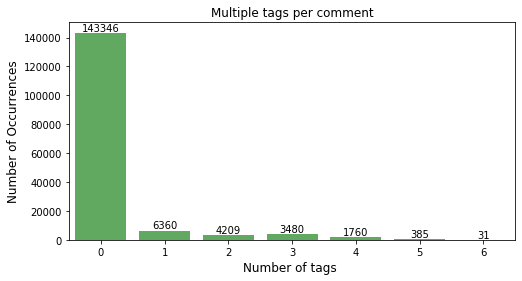

In [7]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()



# Correlation Plot & Confusion Matrix
Now let's have a look at how often the tags occur together by crezting a correlation plot and filtering out the clean data.

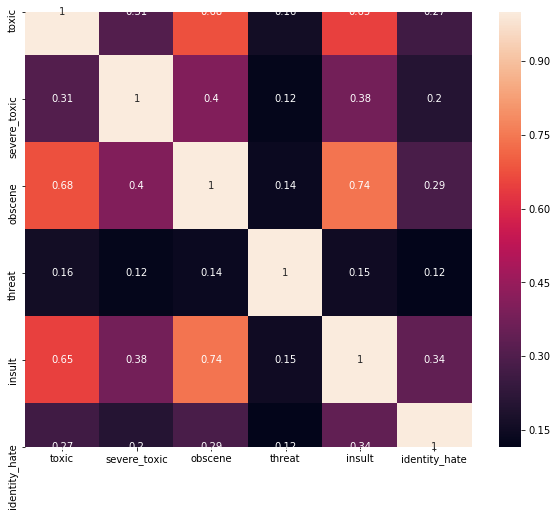

In [8]:
temp_df=train.iloc[:,2:-1]
# filter data by removing the clean comments

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [9]:
def highlight_min(data, color='red'):
    '''
    Finding the maximum in the DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''), index=data.index, columns=data.columns)

In [10]:
# Vizualizing the toxic tags with Crosstab
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

The table above is a reprenstion of a Crosstab/consufion matix of the Toxic comments.

In [11]:
def cramers_corrected_stat(confusion_matrix):
    """ Calculating Cramers V statistic for categorial-categorial association.
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [12]:
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix for toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramers V statistic=",new_corr)

Confusion matrix for toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramers V statistic= 0.30850290540548614


# Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

Chart Desc: The visuals here are word clouds of the most frequent words. The more they appear the bigger they are displayed. A graphical mask has been added for visual appeal. 

In [13]:
stopword=set(STOPWORDS)

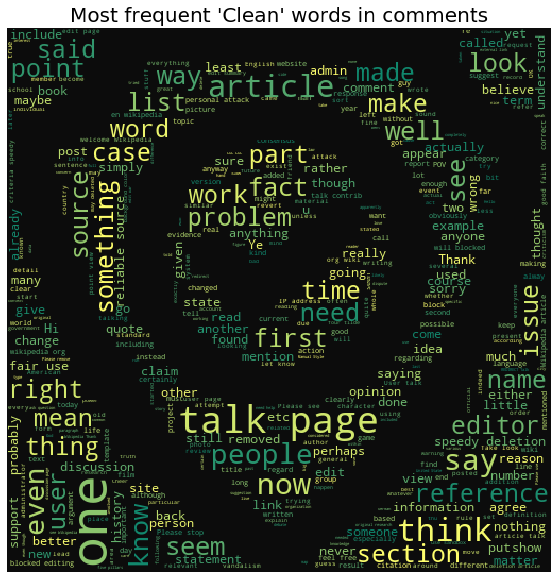

In [14]:
clean_mask=np.array(Image.open("safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=500,mask=clean_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Most frequent 'Clean' words in comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=17), alpha=0.95)
plt.show()



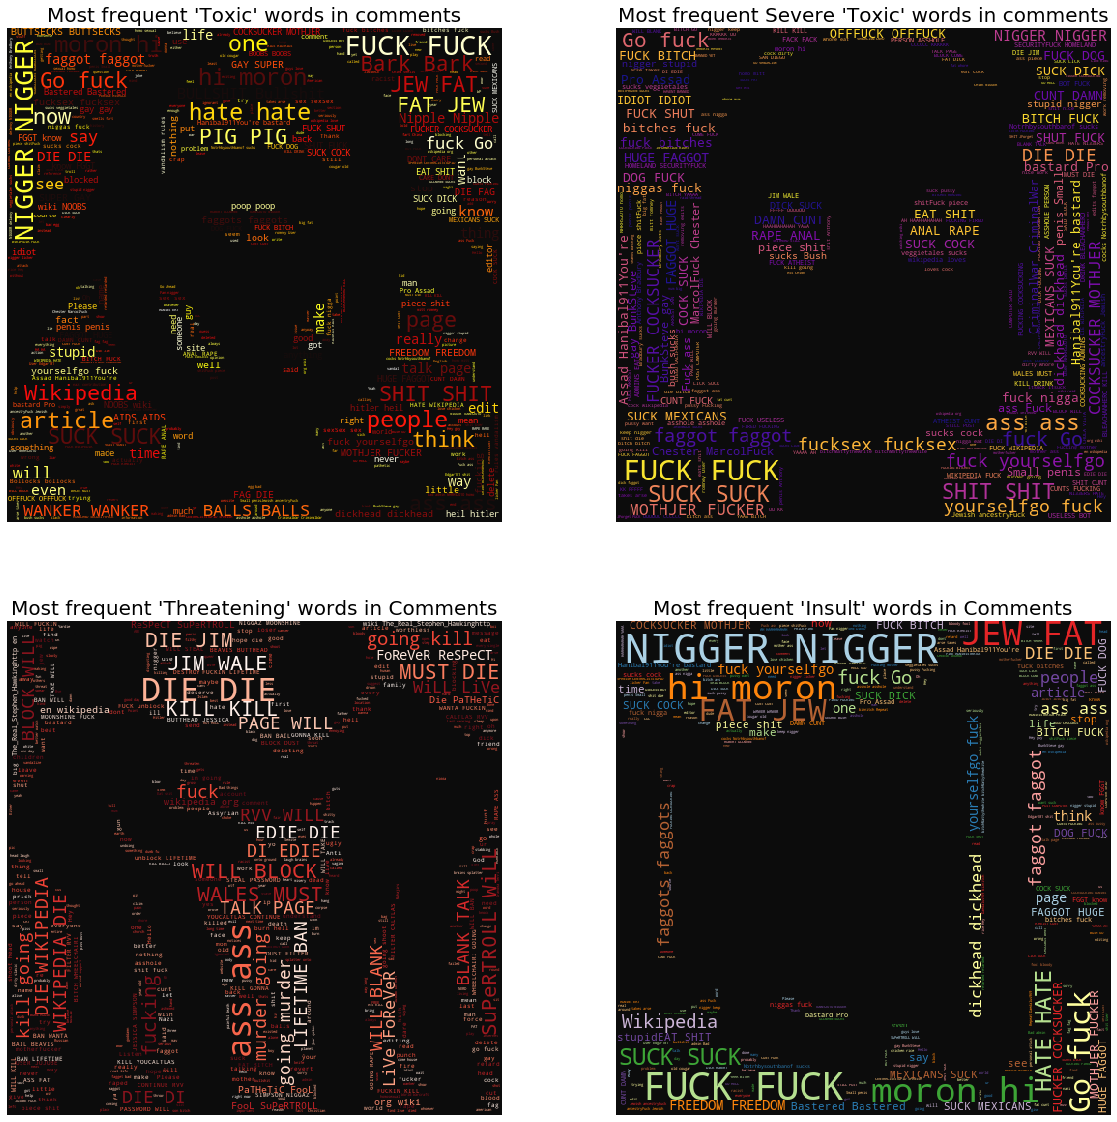

In [15]:
toxic_mask=np.array(Image.open("biohazard-symbol.png"))
toxic_mask=toxic_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=500,mask=toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Most frequent 'Toxic' words in comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'hot' , random_state=244), alpha=0.95)

#Severely toxic comments
plt.subplot(222)
severe_toxic_mask=np.array(Image.open("gas-mask.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=500,mask=severe_toxic_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Most frequent Severe 'Toxic' words in comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'plasma' , random_state=244), alpha=0.95)

#Threat comments
plt.subplot(223)
threat_mask=np.array(Image.open("anger.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=500,mask=threat_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Most frequent 'Threatening' words in Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=2534), alpha=0.95)

#insult
plt.subplot(224)
insult_mask=np.array(Image.open("megaphone.png"))
insult_mask=insult_mask[:,:,1]
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=500,mask=insult_mask,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Most frequent 'Insult' words in Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.95)

plt.show()

# Data presentation and exploration:
The following techniques will be used in this section.

   * Word frequency including:
        * Count features
        * Bigrams
        * Trigrams
   * Vector distance mapping
   * Sentiment scores
   * count of sentences
   * count of words
   * count of unique words
   * count of letters
   * count of punctuations
   * count of uppercase words/letters
   * count of stop words
   * Avg length of each word



In [16]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [17]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [18]:
#serperate trained and test data
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#joining the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

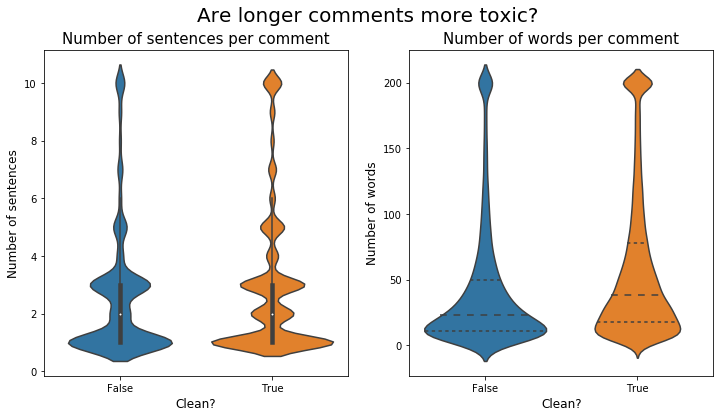

In [22]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('Number of sentences', fontsize=12)
plt.title("Number of sentences per comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('Number of words', fontsize=12)
plt.title("Number of words per comment", fontsize=15)

plt.show()

From the data is seems that longer comments do not seem to be a significant indicator of toxicity.

Chart desc: The inner markings show the percentiles while the width of the violin charts shows the volume of comments at that level.

In [23]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 30% words that are unique
spammers=train_feats[train_feats['word_unique_percent']<30]

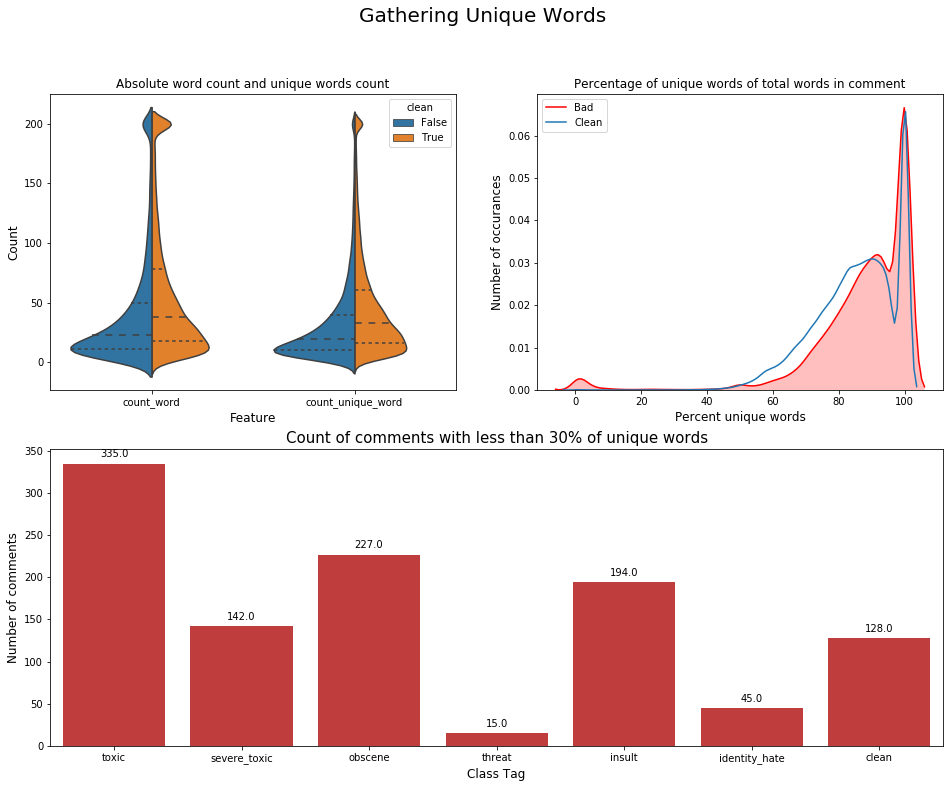

In [24]:
plt.figure(figsize=(16,12))
plt.suptitle("Gathering Unique Words",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute word count and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with less than 30% of unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Class Tag', fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.show()




## Cleaning Leaky Data

Caution: Including this data can lead to unexpected results, it will not make sence to add them into the final model, so the data will be cleaned. 

Here we are creating our own custom count vectorizer to create count variables that match our regex condition

In [25]:
#Leaky Data
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#Find all the links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#get the number of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

# Removing the usernames with a regex
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
# Count the number of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))

# Leaky Ips
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))

# Leaky usernames
cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

# Leaky Usernames

In [26]:
# check names
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

In [27]:
#Leaky Stability:
#Checking the re-occurance of leaky features to check their utility in predicting the test set.
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

# Leaky IPs Count

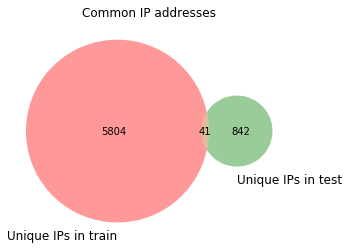

In [28]:
# filter out the data without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
# get the unique ip list in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("Unique IPs in train","Unique IPs in test"))
plt.show()

# Leaky Links Count

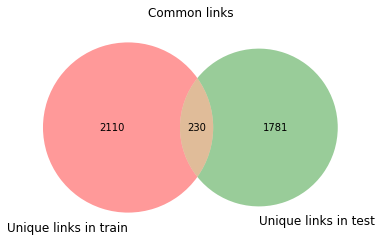

In [29]:
#filter out the data without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)), set_labels=("Unique links in train","Unique links in test"))
plt.show()

# Leaky Usernames Count

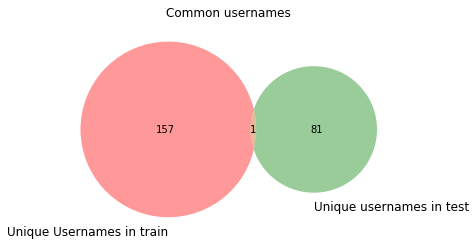

In [30]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("Unique Usernames in train","Unique usernames in test"))
plt.show()

In [1]:
# List of blocked IP addresses.
blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226",
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

# Finding blocked IPs

In [101]:
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
blocked_ip_list_train=list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test=list(set(test_ip_list).intersection(blocked_ips))

print("There are",len(blocked_ip_list_train),"blocked IPs in train dataset")
print("There are",len(blocked_ip_list_test),"blocked IPs in test dataset")

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


In [102]:
end_time=time.time()
print("total time cleaning Leaky Data",end_time-start_time)

total time cleaning Leaky Data 118.08195304870605


# Corpus cleaning:

Cleaning the dataset before counting.

In [103]:
corpus=merge.comment_text

In [104]:
# Lookup dict of common contractions and modern spellings
lDict = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [105]:
def clean(comment):
    """
    This function receives comments and returns cleaned word-list
    """
    #Convert to lower case 
    comment=comment.lower()
    #remove newlines
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip & user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[lDict[word] if word in lDict else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    # returning cleaned data
    clean_sent=" ".join(words)
    return(clean_sent)

# Cleaning data:

### Example corpus data:

In [106]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

### Cleaned corpus data:

In [107]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [108]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("Total time of cleaning the data",end_time-start_time)

Total time of cleaning the data 284.23581433296204


# Direct features:
1)Count based features(for unigrams):

Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Using Python's SKlearn to create a vocabulary(dictionary) then a sparse matrix of word counts for the words in the sentence that are present.
   
Note: Using concatenated dataframe "merge" which contains both the data from train and test dataset to ensure that  we do not missout on the words that are unique to each set.


In [109]:
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [110]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that are most important in rows indentified by grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [111]:
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time in Ngrams",end_unigrams-start_time)

total time in unigrams 47.165364265441895
total time till unigrams 331.4242422580719


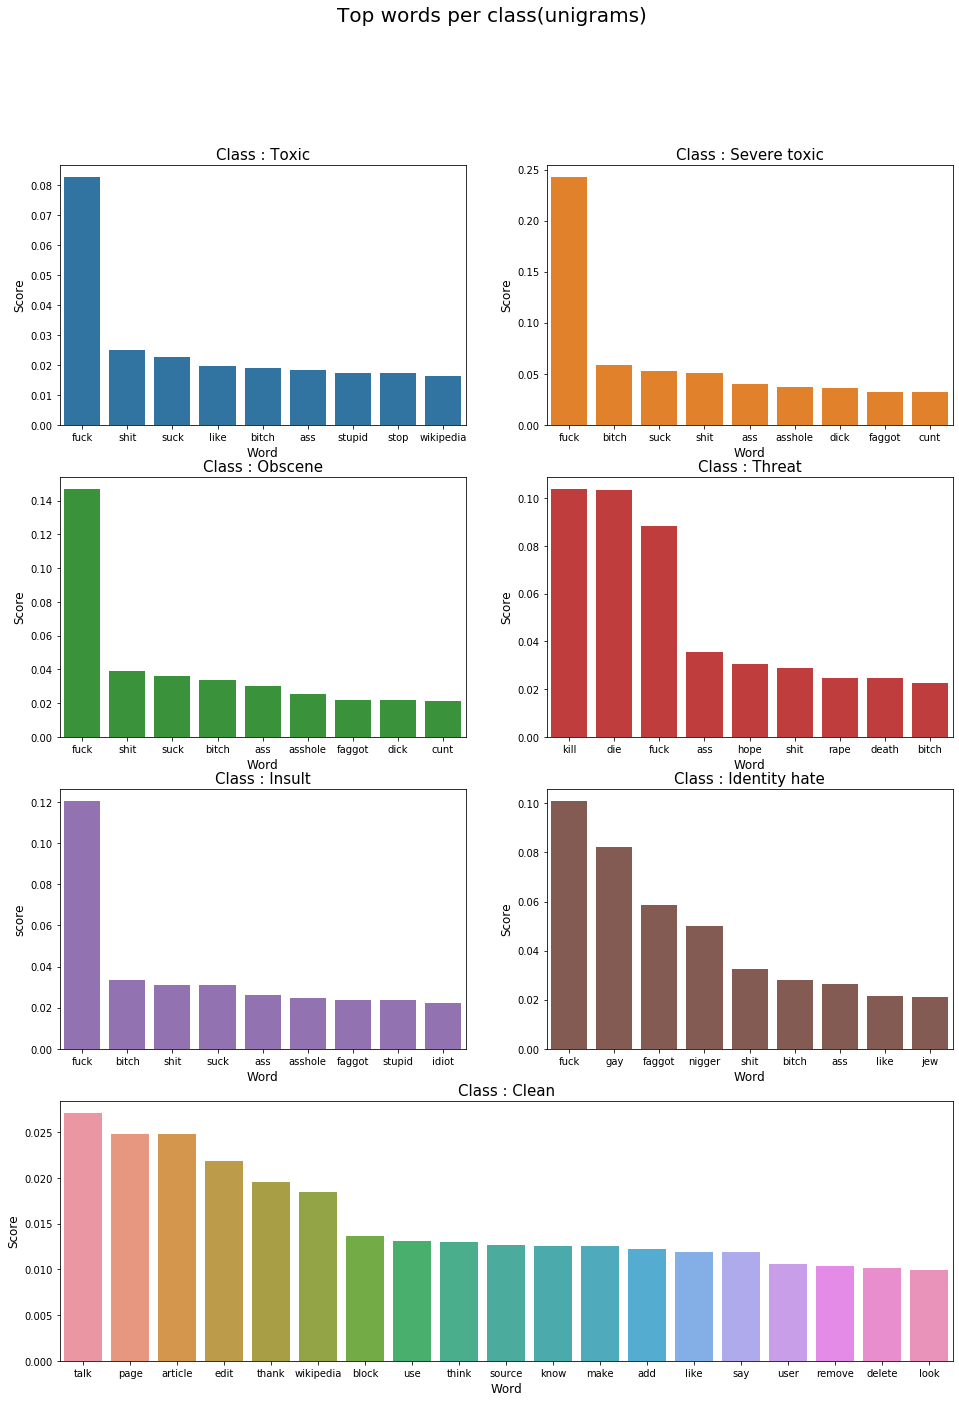

In [112]:
plt.figure(figsize=(16,22))
plt.suptitle("Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("Class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("Class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("Class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("Class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("Class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("Class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("Class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.show()

In [113]:
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

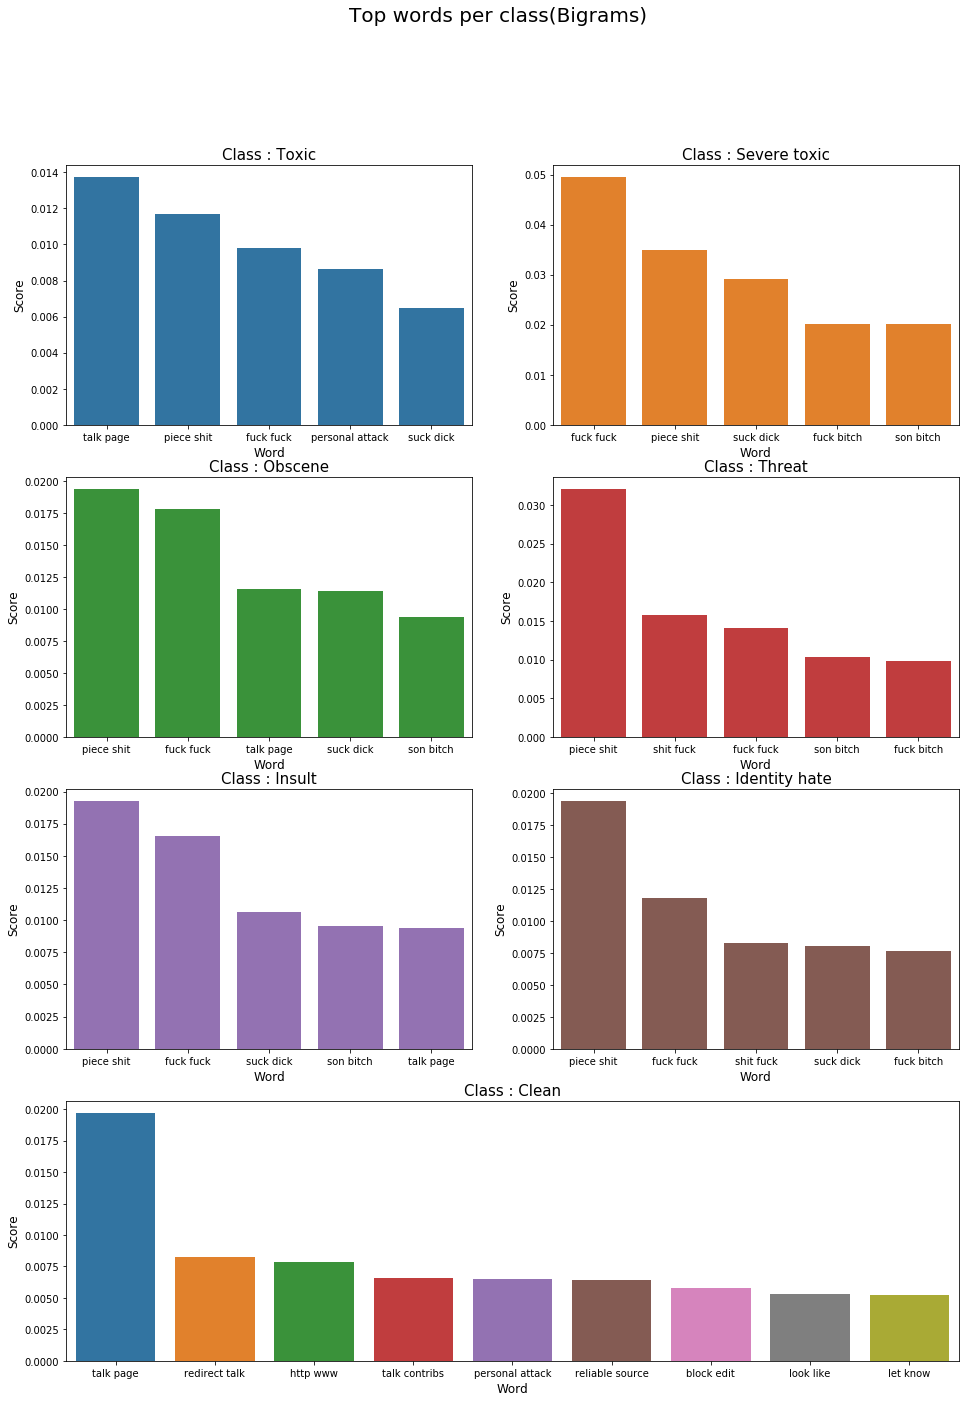

In [114]:
plt.figure(figsize=(16,22))
plt.suptitle("Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("Class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("Class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("Class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("Class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("Class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("Class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("Class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.show()

In [115]:
end_time=time.time()
print("total time for unigrams & bigrams count",end_time-start_time)

total time for unigrams & bigrams count 394.46695923805237


In [116]:
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time=time.time()
print("total time for the ngrams",end_time-start_time)

total time for the ngrams 855.1707162857056


In [117]:
# Baseline Model:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [118]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]


In [119]:

print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)), dtype=np.float64)
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)), dtype=np.float64)
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("Total time for Indirect feat model",end_time-start_time)

Using only Indirect features
Class:= toxic
Trainloss=log loss: 0.3009445063184722
Validloss=log loss: 0.3000824101795967
Class:= severe_toxic
Trainloss=log loss: 0.05048010934449732
Validloss=log loss: 0.05166794164872536
Class:= obscene
Trainloss=log loss: 0.1997549812663233
Validloss=log loss: 0.19806102599110711
Class:= threat
Trainloss=log loss: 0.01977152040060687
Validloss=log loss: 0.019228695141152517
Class:= insult
Trainloss=log loss: 0.18859304585564415
Validloss=log loss: 0.18981868052160533
Class:= identity_hate
Trainloss=log loss: 0.047831964459827736
Validloss=log loss: 0.05133031765313224
mean column-wise log loss:Train dataset 0.13456268794089526
mean column-wise log loss:Validation dataset 0.13503151185588655
Total time for Indirect feat model 872.3856461048126


In [120]:
importance[0][0]

array([ 3.98823934e-02,  2.47124288e-03, -2.46646880e-02,  1.99506683e-04,
        1.36123468e-03,  5.09805921e-02, -1.77109252e-02,  5.01098837e-03,
       -1.26865148e-03, -2.85927458e-03, -3.39294272e-05])

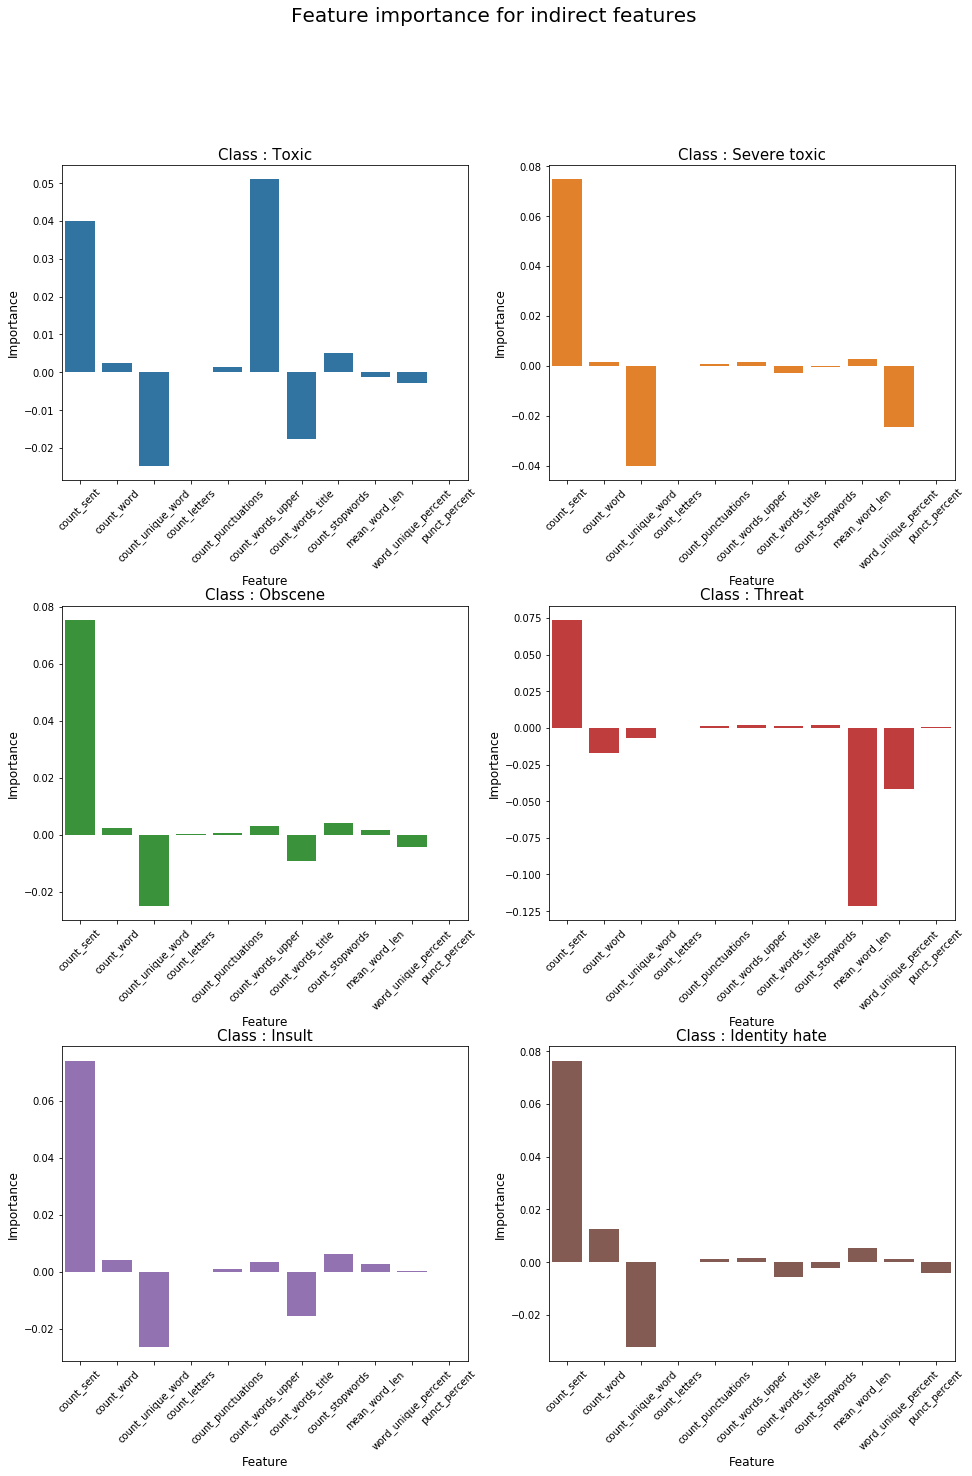

In [121]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("Class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("Class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("Class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("Class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("Class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("Class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.show()

In [122]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except the leaky ones")
target_x = hstack((train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()


end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time)

Using all features except the leaky ones
total time till Sparse mat creation 880.9988832473755


In [123]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)), dtype=np.float64)
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)), dtype=np.float64)
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('Mean column-wise loss: Train dataset', np.mean(train_loss))
print('Mean column-wise loss: Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("Total time for NB base model creation",end_time-start_time)

Class:= toxic
Trainloss=log loss: 0.12561558174055648
Validloss=log loss: 0.13257933724944718
Class:= severe_toxic
Trainloss=log loss: 0.032426374816528235
Validloss=log loss: 0.03664143646334287
Class:= obscene
Trainloss=log loss: 0.08052903631852576
Validloss=log loss: 0.08017508556190277
Class:= threat
Trainloss=log loss: 0.01027588864200188
Validloss=log loss: 0.014056367552859913
Class:= insult
Trainloss=log loss: 0.15245857322790307
Validloss=log loss: 0.17157725443389493
Class:= identity_hate
Trainloss=log loss: 0.0687957143719264
Validloss=log loss: 0.0763706812657443
Mean column-wise loss: Train dataset 0.07835019485290697
Mean column-wise loss: Validation dataset 0.08523336042119867
Total time for NB base model creation 1050.2857520580292
